# Generate vehicle routing problem instance

In [1]:
import qiskit
print(qiskit.version.get_version_info())

2.1.1


In [2]:
import numpy as np
from collections.abc import Callable, Iterable

n = 5  # number of nodes + depot (n+1)
K = 2  # number of vehicles

# Get randomly placed nodes
class Initializer:
    def __init__(self, n):
        self.n = n

    def generate_instance(self):
        n = self.n

        np.random.seed(1543)

        xc = (np.random.rand(n) - 0.5) * 10
        yc = (np.random.rand(n) - 0.5) * 10

        instance = np.zeros([n, n])
        for ii in range(0, n):
            for jj in range(ii + 1, n):
                instance[ii, jj] = (xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2
                instance[jj, ii] = instance[ii, jj]

        return xc, yc, instance
    
initializer = Initializer(n)
xc, yc, instance = initializer.generate_instance()

In [3]:
print(instance)

[[ 0.         18.49824748 13.70651823 31.94890118 17.21499136]
 [18.49824748  0.         10.32503044 52.54265146  0.38783704]
 [13.70651823 10.32503044  0.         16.51217558 13.21347497]
 [31.94890118 52.54265146 16.51217558  0.         57.84738226]
 [17.21499136  0.38783704 13.21347497 57.84738226  0.        ]]


In [4]:
print(xc, yc)

[ 0.51003914  2.55963937 -0.64283509 -4.57068577  2.98724481] [-2.72584275  1.05534574  0.79231007 -0.24892217  0.60258683]


# Functions to convert problem to QUBO


In [5]:
import networkx as nx
import itertools
from docplex.mp.model import Model
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.problems import QuadraticProgram


def vehicle_routing_to_quadratic_program(graph: nx.Graph, depot: int, num_vehicles: int) -> QuadraticProgram:
    """
    Convert a vehicle routing problem instance into a QuadraticProgram.

    Args:
        graph: A networkx graph with edge weights representing distances or costs.
        depot: The index of the depot node.
        num_vehicles: The number of vehicles available.

    Returns:
        A QuadraticProgram representing the vehicle routing problem.
    """
    mdl = Model(name="Vehicle routing")
    n = graph.number_of_nodes()
    x = {}

    # Binary variables: x_ij = 1 if vehicle goes from node i to node j
    for i in range(n):
        for j in range(n):
            if i != j:
                x[(i, j)] = mdl.binary_var(name=f"x_{i}_{j}")

    # Objective: Minimize total travel cost
    mdl.minimize(
        mdl.sum(
            graph.edges[i, j]["weight"] * x[(i, j)]
            for i in range(n)
            for j in range(n)
            if i != j
        )
    )

    # Each node (except depot) has one outgoing and one incoming edge
    for i in range(n):
        if i != depot:
            mdl.add_constraint(mdl.sum(x[i, j] for j in range(n) if i != j) == 1)
    for j in range(n):
        if j != depot:
            mdl.add_constraint(mdl.sum(x[i, j] for i in range(n) if i != j) == 1)

    # Depot constraints: exactly num_vehicles enter and leave
    mdl.add_constraint(
        mdl.sum(x[i, depot] for i in range(n) if i != depot) == num_vehicles
    )
    mdl.add_constraint(
        mdl.sum(x[depot, j] for j in range(n) if j != depot) == num_vehicles
    )

    # Sub-tour elimination (using clique constraints)
    node_list = [i for i in range(n) if i != depot]
    for i in range(2, len(node_list) + 1):
        for clique in itertools.combinations(node_list, i):
            mdl.add_constraint(
                mdl.sum(x[i, j] for i in clique for j in clique if i != j) <= len(clique) - 1
            )

    # Convert to QuadraticProgram
    qp = from_docplex_mp(mdl)
    return qp, mdl


def vehicle_routing_to_objective(graph: nx.Graph, depot: int, num_vehicles: int) -> QuadraticProgram:
    mdl = Model(name="Vehicle routing obj")
    n = graph.number_of_nodes()
    x = {}
    # Binary variables: x_ij = 1 if vehicle goes from node i to node j
    for i in range(n):
        for j in range(n):
            if i != j:
                x[(i, j)] = mdl.binary_var(name=f"x_{i}_{j}")
    # Objective: Minimize total travel cost
    mdl.minimize(
        mdl.sum(
            graph.edges[i, j]["weight"] * x[(i, j)]
            for i in range(n)
            for j in range(n)
            if i != j
        )
    )
    # Convert to QuadraticProgram
    qp = from_docplex_mp(mdl)
    return qp

# Constrained Linear Problem

In [6]:
import matplotlib.pyplot as plt

G = nx.Graph()

# Add nodes and edges from the distance matrix
num_nodes = instance.shape[0]
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):  # Avoid duplicate edges
        if instance[i, j] > 0:  # skip zero or invalid distances
            G.add_edge(i, j, weight=instance[i, j])

vrp3, mdl = vehicle_routing_to_quadratic_program(G, depot=0, num_vehicles=K)
print(vrp3.prettyprint())

Problem name: Vehicle routing

Minimize
  18.498247483507754*x_0_1 + 13.706518226906649*x_0_2 + 31.948901177444597*x_0_3
  + 17.21499136106496*x_0_4 + 18.498247483507754*x_1_0
  + 10.325030435068514*x_1_2 + 52.54265146426326*x_1_3
  + 0.38783704124119656*x_1_4 + 13.706518226906649*x_2_0
  + 10.325030435068514*x_2_1 + 16.512175582150128*x_2_3
  + 13.213474967575133*x_2_4 + 31.948901177444597*x_3_0
  + 52.54265146426326*x_3_1 + 16.512175582150128*x_3_2 + 57.84738225636074*x_3_4
  + 17.21499136106496*x_4_0 + 0.38783704124119656*x_4_1
  + 13.213474967575133*x_4_2 + 57.84738225636074*x_4_3

Subject to
  Linear constraints (21)
    x_1_0 + x_1_2 + x_1_3 + x_1_4 == 1  'c0'
    x_2_0 + x_2_1 + x_2_3 + x_2_4 == 1  'c1'
    x_3_0 + x_3_1 + x_3_2 + x_3_4 == 1  'c2'
    x_4_0 + x_4_1 + x_4_2 + x_4_3 == 1  'c3'
    x_0_1 + x_2_1 + x_3_1 + x_4_1 == 1  'c4'
    x_0_2 + x_1_2 + x_3_2 + x_4_2 == 1  'c5'
    x_0_3 + x_1_3 + x_2_3 + x_4_3 == 1  'c6'
    x_0_4 + x_1_4 + x_2_4 + x_3_4 == 1  'c7'
    x_1_0 

In [7]:
num_variables = len(vrp3.variables)

In [8]:
from qiskit_optimization.converters import QuadraticProgramToQubo

conv = QuadraticProgramToQubo(penalty=np.sum(instance)*2)    # ..............PENALTY................
qubo_with_constraints = conv.convert(vrp3)
print(qubo_with_constraints.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Vehicle routing

Minimize
 obj: - 5554.234792410482 x_0_1 - 5559.026521667084 x_0_2
      - 5540.784138716546 x_0_3 - 5555.518048532926 x_0_4
      - 5554.234792410482 x_1_0 - 16707.874089246903 x_1_2
      - 16665.656468217709 x_1_3 - 16717.811282640730 x_1_4
      - 5559.026521667084 x_2_0 - 16707.874089246903 x_2_1
      - 16701.686944099820 x_2_3 - 16704.985644714397 x_2_4
      - 5540.784138716546 x_3_0 - 16665.656468217709 x_3_1
      - 16701.686944099820 x_3_2 - 16660.351737425612 x_3_4
      - 5555.518048532926 x_4_0 - 16717.811282640730 x_4_1
      - 16704.985644714397 x_4_2 - 16660.351737425612 x_4_3
      - 3715.155359929327 c16@int_slack@0 - 3715.155359929327 c16@int_slack@1
      - 3715.155359929327 c17@int_slack@0 - 3715.155359929327 c17@int_slack@1
      - 3715.155359929327 c18@int_slack@0 - 3715.155359929327 c18@int_slack@1
      - 3715.155359929327 c19@int_slack@0 - 3715.155359929327 c19@int

In [9]:
num_qubits = len(qubo_with_constraints.variables)
print("Number of variables: ", num_variables)
print("number of qubits: ", num_qubits)

Number of variables:  20
number of qubits:  30


In [10]:
Q = qubo_with_constraints.objective.quadratic.to_array()

# Simplify diagonal terms: x^2 = x, move diagonal elements to linear and zero them out
linear = qubo_with_constraints.objective.linear.to_array()
diag = np.diag(Q)

# Update linear: x^2 term becomes x
simplified_linear = linear + diag

# Zero out the diagonal in the quadratic matrix
np.fill_diagonal(Q, 0)

In [11]:
def build_qubo_from_arrays(linear, quadratic, variable_names=None):
    n = len(linear)
    qp = QuadraticProgram()
    
    # If variable names are not given, create default names
    if variable_names is None:
        variable_names = [f'x{i}' for i in range(n)]
    
    # Add binary variables
    for name in variable_names:
        qp.binary_var(name._name)
    
    # Add objective: minimize linear + quadratic terms
    linear_dict = {variable_names[i]._name: linear[i] for i in range(n)}
    
    # Only use upper triangle of Q to avoid double-counting
    quadratic_dict = {}
    for i in range(n):
        for j in range(i + 1, n):
            if quadratic[i, j] != 0:
                quadratic_dict[(variable_names[i]._name, variable_names[j]._name)] = quadratic[i, j]
          
    max_lin_coeff = max(abs(v) for v in linear_dict.values())
    max_quad_coeff = max(abs(v) for v in quadratic_dict.values())

    # Normalize coefficients
    if max_lin_coeff > max_quad_coeff:
        linear_dict_normed = {k: v / max_lin_coeff for k, v in linear_dict.items()}
        quadratic_dict_normed = {k: v / max_lin_coeff for k, v in quadratic_dict.items()}
    else:
        linear_dict_normed = {k: v / max_quad_coeff for k, v in linear_dict.items()}
        quadratic_dict_normed = {k: v / max_quad_coeff for k, v in quadratic_dict.items()}        
    
    qp.minimize(linear=linear_dict_normed, quadratic=quadratic_dict_normed)    
    
    return qp

## Build normalized QUBO

In [12]:
qubo_simple = build_qubo_from_arrays(simplified_linear, Q, variable_names=qubo_with_constraints.variables)
print(qubo_simple.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 0.306170101685 x_0_1 - 0.306566969500 x_0_2 - 0.305056071391 x_0_3
      - 0.306276385455 x_0_4 - 0.306170101685 x_1_0 - 0.999176966806 x_1_2
      - 0.995680355427 x_1_3 - x_1_4 - 0.306566969500 x_2_0
      - 0.999176966806 x_2_1 - 0.998664525754 x_2_3 - 0.998937735703 x_2_4
      - 0.305056071391 x_3_0 - 0.995680355427 x_3_1 - 0.998664525754 x_3_2
      - 0.995240999025 x_3_4 - 0.306276385455 x_4_0 - x_4_1
      - 0.998937735703 x_4_2 - 0.995240999025 x_4_3
      - 0.230776643544 c16@int_slack@0 - 0.230776643544 c16@int_slack@1
      - 0.230776643544 c17@int_slack@0 - 0.230776643544 c17@int_slack@1
      - 0.230776643544 c18@int_slack@0 - 0.230776643544 c18@int_slack@1
      - 0.230776643544 c19@int_slack@0 - 0.230776643544 c19@int_slack@1
      - 0.384627739240 c20@int_slack@0 - 0.615404382784 c20@int_slack@1 + [
      0.307702191392 x_0_1*x_0_2 + 0.307702191392 x_0_1*x_0_3
      +

In [15]:
def calculate_cost(state, qubo):
    n = len(qubo.variables)
    x = np.fromiter(((state >> i) & 1 for i in range(n)), dtype=np.int8, count=n)
    return qubo.objective.evaluate(x)

In [16]:
ising_H_full = qubo_simple.to_ising()[0]
# print(ising_H_full)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIZIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIZIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIZIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIZIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIZIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIZIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIZIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIZIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIIIIIIIIIIIIII',

## Remove non-adjacent ZZ connections

In [17]:
from qiskit.quantum_info import SparsePauliOp

def filter_adjacent_ZZ(op: SparsePauliOp) -> SparsePauliOp:
    """
    Keep only terms with ZZ on consecutive qubits in a SparsePauliOp.
    """
    new_paulis = []
    new_coeffs = []

    for pauli, coeff in zip(op.paulis, op.coeffs):
        # Identify positions where this term has a Z
        z_positions = [i for i, p in enumerate(pauli.to_label()) if p == 'Z']
        
        # Case: exactly two Zs, and they are adjacent
        if len(z_positions) == 2 and abs(z_positions[0] - z_positions[1]) == 1:
            new_paulis.append(pauli)
            new_coeffs.append(coeff)
        # Keep identity or single-Z terms if you want
        elif len(z_positions) <= 1:
            new_paulis.append(pauli)
            new_coeffs.append(coeff)
        # Drop everything else

    return SparsePauliOp(new_paulis, coeffs=new_coeffs)

In [18]:
ising_H = filter_adjacent_ZZ(ising_H_full)
print(ising_H)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIZIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIZIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIZIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIZIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIZIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIZIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIZIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIZIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIIIIIIIIIIIIII',

# Qiskit QAOA Ansatz to create parametrized circuit 

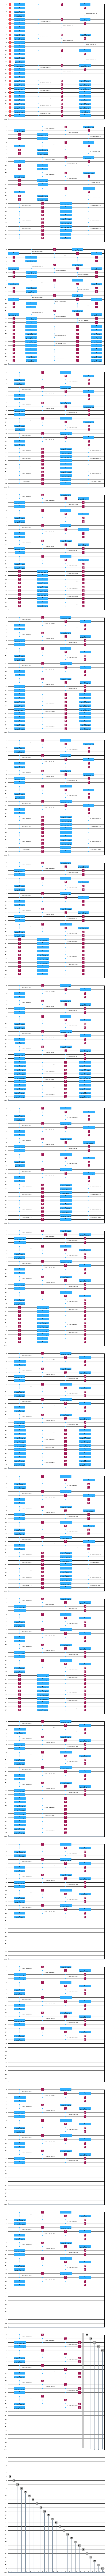

In [20]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=ising_H, reps=20, flatten=True)
circuit.measure_all()

circuit.draw('mpl', scale=0.5)

In [21]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(β[3]), ParameterVectorElement(β[4]), ParameterVectorElement(β[5]), ParameterVectorElement(β[6]), ParameterVectorElement(β[7]), ParameterVectorElement(β[8]), ParameterVectorElement(β[9]), ParameterVectorElement(β[10]), ParameterVectorElement(β[11]), ParameterVectorElement(β[12]), ParameterVectorElement(β[13]), ParameterVectorElement(β[14]), ParameterVectorElement(β[15]), ParameterVectorElement(β[16]), ParameterVectorElement(β[17]), ParameterVectorElement(β[18]), ParameterVectorElement(β[19]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1]), ParameterVectorElement(γ[2]), ParameterVectorElement(γ[3]), ParameterVectorElement(γ[4]), ParameterVectorElement(γ[5]), ParameterVectorElement(γ[6]), ParameterVectorElement(γ[7]), ParameterVectorElement(γ[8]), ParameterVectorElement(γ[9]), ParameterVectorElement(γ[10]), ParameterVectorElement(γ[11]), ParameterVect

In [22]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import generate_preset_pass_manager

service = QiskitRuntimeService(name="saved_service_name")
backend = service.backend("ibm_fez")
# backend = service.backend("ibm_rensselaer")
print(backend)
rpi_coupling_map = backend.coupling_map

<IBMBackend('ibm_fez')>


# Transpile circuit

In [23]:
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
candidate_circuit = pm.run(circuit)

In [25]:
print(candidate_circuit.count_ops())

OrderedDict([('rz', 3460), ('sx', 2430), ('cz', 800), ('measure', 30), ('barrier', 1)])


In [26]:
two_qubit_gate_depth = candidate_circuit.depth(lambda x: x.operation.num_qubits == 2)
print(two_qubit_gate_depth)

82


# Initialize parameters and define cost estimator

In [28]:
# Linear Ramp schedule
p = len(circuit.parameters)//2
d_B = 0.3
d_G = 0.6
lr_betas=np.zeros(p)
lr_gammas=np.zeros(p)
for i in range(p):
    lr_betas[i] = d_B*(1-i/p)
    lr_gammas[i] = d_G*(i+1)/p

In [ ]:
initial_gamma = np.pi
initial_beta = np.pi/2

# init_params = [initial_gamma, initial_beta] * (len(circuit.parameters)//2)    # standard initialization

init_params = [val for pair in zip(lr_gammas, lr_betas) for val in pair]    # Linear Ramp initialization

## from AER training of depth 4 QAOA, itself starting with LR params for the n=4, K=2 problem
# init_params = [-0.2636875, 0.0592173, 0.26269656, 0.26329161, 0.16341161, -0.8136479, 0.15121482, -1.11689571]

print(init_params)

# transform the observable defined on virtual qubits to all physical qubits
isa_hamiltonian = ising_H_full.apply_layout(candidate_circuit.layout)

In [ ]:
def qaoa_sampler_cost_fun(
    params, ansatz, hamiltonian, sampler, aggregation=None
):
    """Standard sampler-based QAOA cost function with CVaR.
 
    Args:
        params (np.ndarray): Parameters for the ansatz.
        ansatz (QuantumCircuit): Ansatz circuit.
        hamiltonian (SparsePauliOp): Hamiltonian to be minimized.
        sampler (QAOASampler): Sampler to be used.
        aggregation (Callable | float | None): Aggregation function to be applied to
            the sampled results. If None, the sum of the expectation values is returned.
            If float, the CVaR with the given alpha is used.
    """
    # Run the circuit
    job = sampler.run([(ansatz, params)])
    sampler_result = job.result()
    sampled_int_counts = sampler_result[0].data.meas.get_int_counts()
    shots = sum(sampled_int_counts.values())
    int_count_distribution = {
        key: val / shots for key, val in sampled_int_counts.items()
    }

    # a dictionary containing: {state: (measurement probability, value)}
    evaluated = {
        state: (
            probability,
            calculate_cost(state, qubo_simple),
        )
        for state, probability in int_count_distribution.items()
    }
 
    # If aggregation is None, return the sum of the expectation values.
    # If aggregation is a float, return the CVaR with the given alpha.
    # Otherwise, use the aggregation function.
    if aggregation is None:
        result = sum(
            probability * value for probability, value in evaluated.values()
        )
    elif isinstance(aggregation, float):
        cvar_aggregation = _get_cvar_aggregation(aggregation)
        result = cvar_aggregation(evaluated.values())
    else:
        result = aggregation(evaluated.values())
 
    global iter_counts, result_dict
    iter_counts += 1
    temp_dict = {}
    temp_dict["params"] = params.tolist()
    temp_dict["cvar_fval"] = result
    temp_dict["fval"] = sum(
        probability * value for probability, value in evaluated.values()
    )
    temp_dict["distribution"] = sampled_int_counts
    temp_dict["evaluated"] = evaluated
    result_dict[iter_counts] = temp_dict
 
    return result
 
 
def _get_cvar_aggregation(alpha: float | None) -> Callable:
    """Return the CVaR aggregation function with the given alpha.
 
    Args:
        alpha (float | None): Alpha value for the CVaR aggregation. If None, 1 is used
            by default.
    Raises:
        ValueError: If alpha is not in [0, 1].
    """
    if alpha is None:
        alpha = 1
    elif not 0 <= alpha <= 1:
        raise ValueError(f"alpha must be in [0, 1], but {alpha} was given.")
 
    def cvar_aggregation(
        objective_dict: Iterable[tuple[float, float]],
    ) -> float:
        """Return the CVaR of the given measurements.
        Args:
            objective_dict (Iterable[tuple[float, float]]): An iterable of tuples containing
                the measured bit string and the objective value based on the bit string.
 
        """
        sorted_measurements = sorted(objective_dict, key=lambda x: x[1])
        # accumulate the probabilities until alpha is reached
        accumulated_percent = 0.0
        cvar = 0.0
        for probability, value in sorted_measurements:
            cvar += value * min(probability, alpha - accumulated_percent)
            accumulated_percent += probability
            if accumulated_percent >= alpha:
                break
        return cvar / alpha
 
    return cvar_aggregation

In [53]:
for el in backend.properties().general:
    if el.name[:2] == "lf" and el.name[3:] == str(num_qubits):
        lf = el.value  # layer fidelity
        print("layer fidelity", lf)
        eplg = 1 - lf ** (1 / (num_qubits - 1))  # error per layered gate (EPLG)
        fid_cx = 1 - eplg
        gamma_cx = 1 / fid_cx**2
        gamma_circ = gamma_cx * two_qubit_gate_depth
 
cvar_aggregation = 1 / np.sqrt(gamma_circ)
print(cvar_aggregation)

layer fidelity 0.8673758060151054
0.10989104193773339


## Run QAOA

In [31]:
%%time
from scipy.optimize import minimize
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XpXm"

#Pauli twirling
# estimator.options.twirling.enable_gates = True
# estimator.options.twirling.num_randomizations = "auto"

#Additional noise mitigation TREX = Twirled Readout Error EXtinction
# estimator.options.resilience.measure_mitigation = True
# estimator.options.resilience.measure_noise_learning.num_randomizations = 32
# estimator.options.resilience.measure_noise_learning.shots_per_randomization = 'auto'

# # Zero noise extrapolation
# estimator.options.resilience.zne_mitigation = True
# estimator.options.resilience.zne.noise_factors = (1, 3, 5)
# estimator.options.resilience.zne.amplifier = 'gate_folding'
# estimator.options.resilience.zne.extrapolator = ('exponential','linear')

# Probabilistic error amplification
# estimator.options.resilience.zne_mitigation = True
# estimator.options.resilience.zne.amplifier = "pea"

iter_counts = 0
result_dict = {}

result = minimize(
    qaoa_sampler_cost_fun,
    init_params,
    args=(candidate_circuit, ising_H_full, sampler, cvar_aggregation),
    method="COBYQA",
    tol=1e-2,
)
    
print(result)

 message: The lower bound for the trust-region radius has been reached
 success: True
  status: 0
     fun: -2.577360933034804
       x: [ 1.073e-01  3.391e-01 ...  6.664e-01  6.899e-02]
     nit: 107
   maxcv: 0.0
    nfev: 291
CPU times: user 31min 18s, sys: 6min 17s, total: 37min 36s
Wall time: 1h 49min 37s


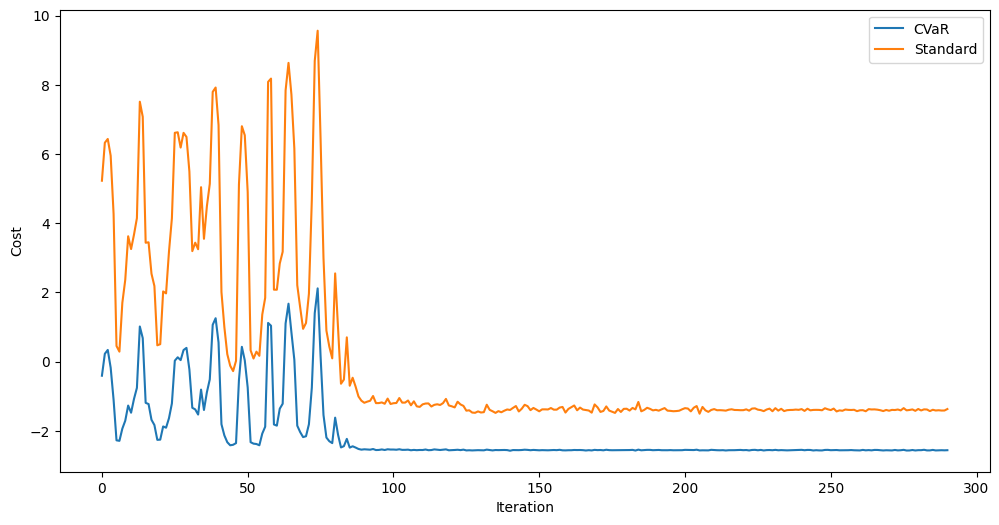

In [33]:
import matplotlib.pyplot as plt
import matplotlib

plt.figure(figsize=(12, 6))
plt.plot(
    [result_dict[i]["cvar_fval"] for i in range(1, iter_counts + 1)],
    label="CVaR",
)
plt.plot(
    [result_dict[i]["fval"] for i in range(1, iter_counts + 1)],
    label="Standard",
)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [34]:
print(iter_counts)
print(result_dict[iter_counts]['params'])
result_x = result_dict[iter_counts]['params']

291
[0.1069150739854457, 0.33925560161454477, 0.06165861934006578, -1.283685070185051, -0.0036223713524826625, 0.23041577217296294, 0.03763627990646403, 0.18941953382143412, 0.09327107539806997, 0.17059496385966016, 0.26124102506721214, 0.339548602061552, 0.29877654245950036, 0.3464457733264492, 0.27058887948836263, 0.2462014337807154, 0.2274436938820683, 0.07608577693685781, 0.24400922614670686, 0.08553929300187936, 0.27468164878713874, 0.19537608874094212, 0.39152638539955953, 0.19856478556840387, 0.4039936149394442, 0.08157375334139824, 0.532282147891041, 0.20759605302256098, 0.5523272748215682, 0.07458968876845157, 0.5335876545125928, 0.01829970667192612, 0.54849867483504, 0.11678098640370291, 0.49245048062788543, 0.1027539495383953, 0.6543114416279533, 0.12121763752874691, 0.6646023019061191, 0.06910483327195932]


In [36]:
optimized_circuit = candidate_circuit.assign_parameters(result_x)
# optimized_circuit.draw('mpl', fold=False, idle_wires=False)

# Run circuit with converged parameters

In [37]:
%%time
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XpXm"

#Pauli twirling
# sampler.options.twirling.enable_gates = True
# sampler.options.twirling.num_randomizations = "auto"

# TREX
# sampler.options.resilience.measure_mitigation = True
# sampler.options.resilience.measure_noise_learning.num_randomizations = 32
# sampler.options.resilience.measure_noise_learning.shots_per_randomization = 100


pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}

CPU times: user 401 ms, sys: 3.77 ms, total: 404 ms
Wall time: 8.15 s


In [38]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, num_variables)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]


/tmp/ipykernel_724884/3202210723.py:3: DeprecationWarning: Insufficient bit width provided. This behavior will raise an error in the future.
  result = np.binary_repr(integer, width=num_bits)


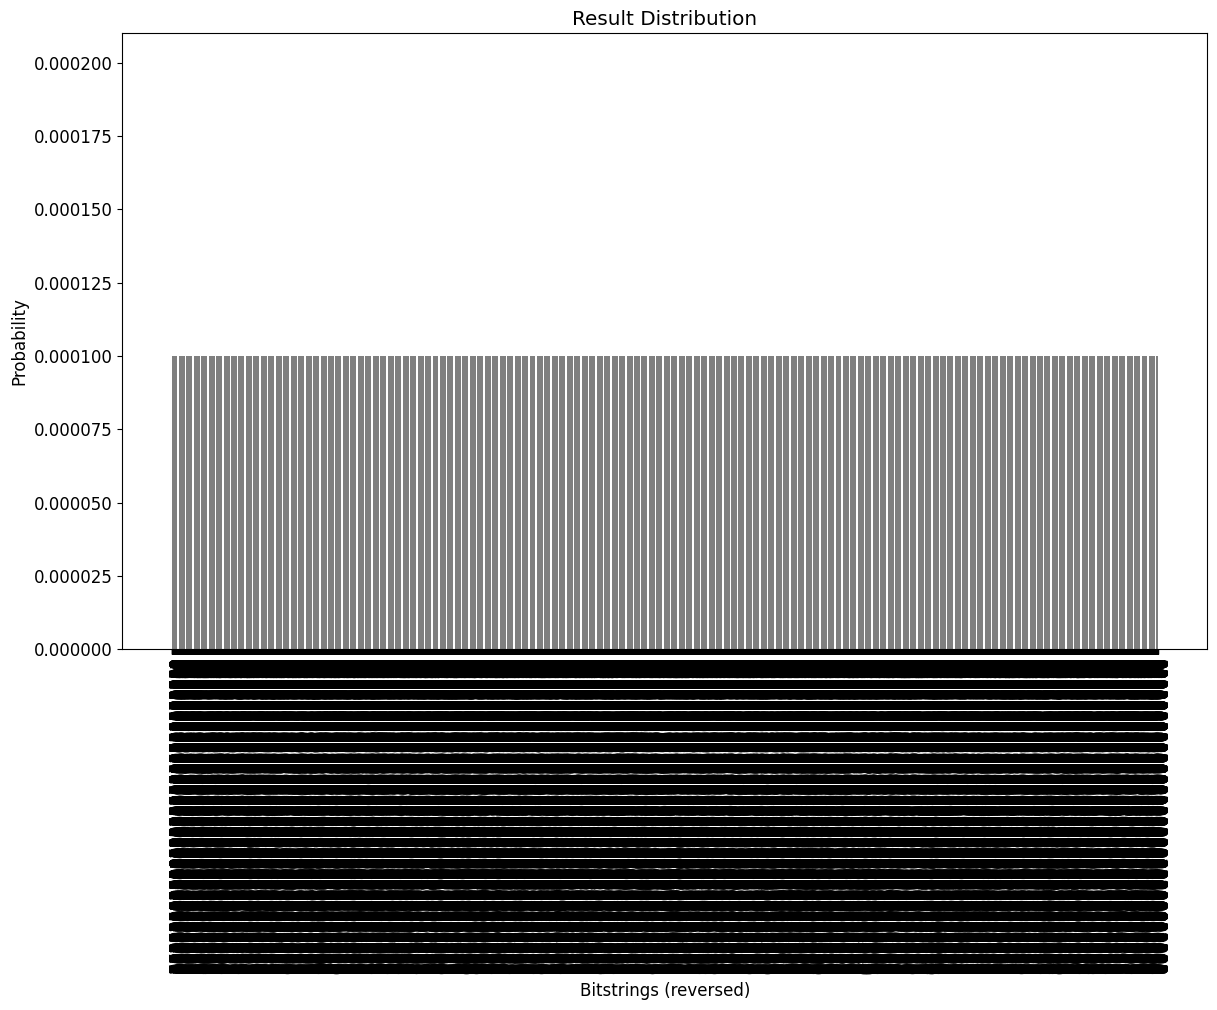

In [39]:
matplotlib.rcParams.update({"font.size": 12})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
# top_4_values = sorted(values, reverse=True)[:4]
# positions = []
# for value in top_4_values:
#     positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=-90)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
plt.show()

## Plot the most frequent bit string

In [40]:
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    # plt.axis("equal")
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color="r")
    plt.plot(xc[0], yc[0], "r*", ms=9)

    plt.grid()

    for ii in range(0, n**2):

        if x[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.quiver(
                xc[ix], yc[ix], xc[iy] - xc[ix], yc[iy] - yc[ix], 
                angles="xy", scale_units="xy", scale=1, color="b", width=0.005, headwidth=7, headlength=7)
    
    plt.title(title_str + " cost = " + str(int(C * 100) / 100.0))
    plt.show()

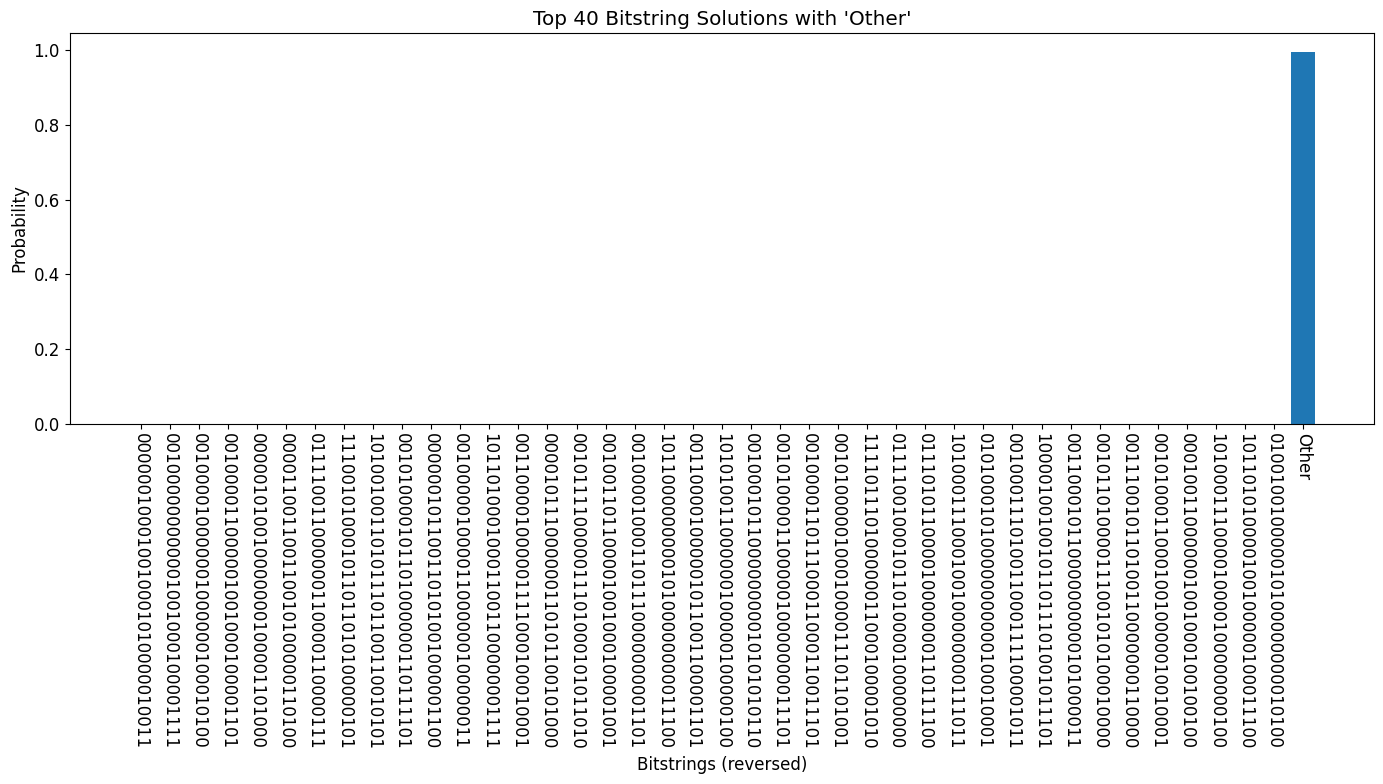

In [41]:
total = sum(final_bits.values())
normalized_bits = {k: v / total for k, v in final_bits.items()}

# Sort and extract top r values
r = 40
sorted_items = sorted(normalized_bits.items(), key=lambda x: x[1], reverse=True)
top_r = sorted_items[:r]
other_sum = sum(val for _, val in sorted_items[r:])

# Prepare labels and values
labels = [k for k, _ in top_r] + ["Other"]
values = [v for _, v in top_r] + [other_sum]

# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=-90)
plt.title(f"Top {r} Bitstring Solutions with 'Other'")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

bars = ax.bar(labels, values, color="tab:blue")

plt.tight_layout()
plt.show()

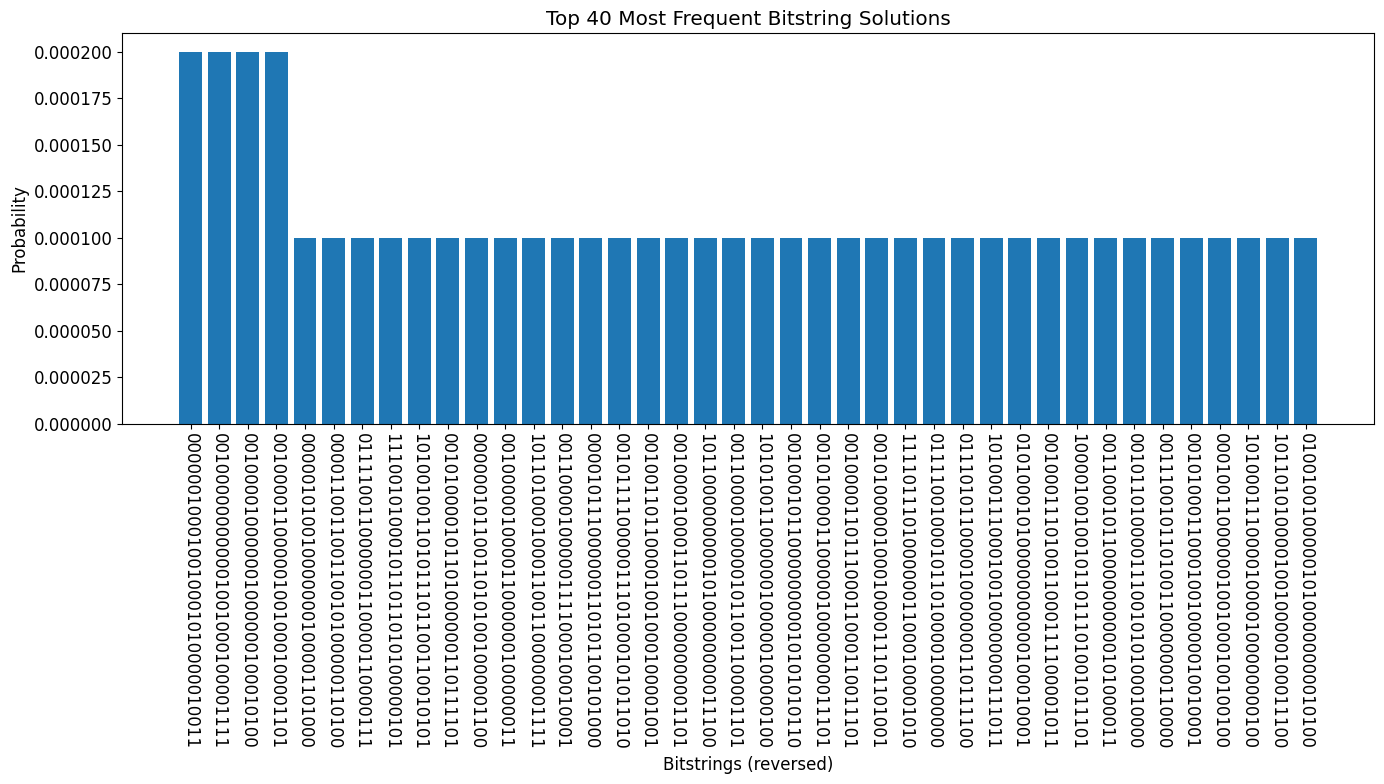

In [42]:
total = sum(final_bits.values())
normalized_bits = {k: v / total for k, v in final_bits.items()}

# Sort and get top r
r = 40
sorted_items = sorted(normalized_bits.items(), key=lambda x: x[1], reverse=True)
top_r = sorted_items[:r]

# Extract bitstrings and probabilities
labels = [k for k, _ in top_r]
values = [v for _, v in top_r]

# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=-90)
plt.title(f"Top {r} Most Frequent Bitstring Solutions")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

bars = ax.bar(labels, values, color="tab:blue")

plt.tight_layout()
plt.show()

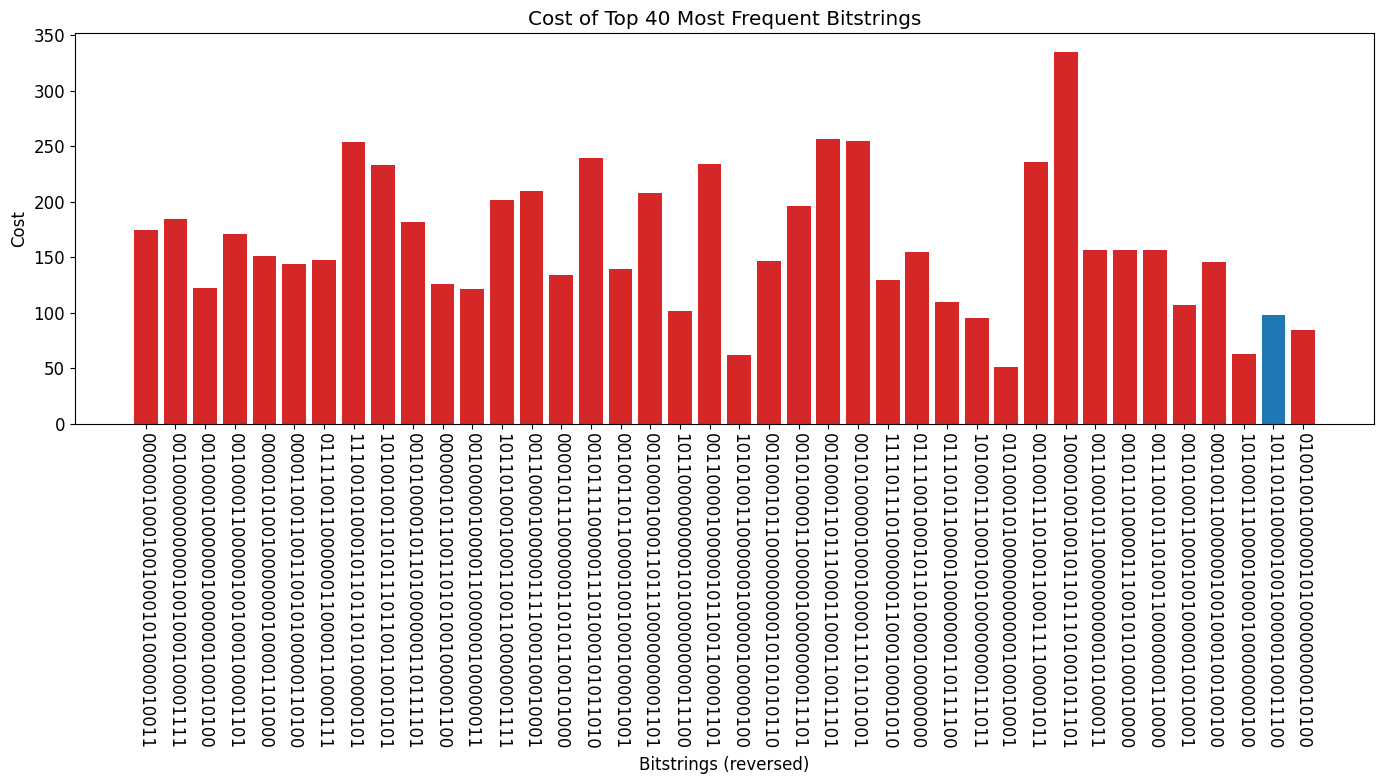

In [43]:
total = sum(final_bits.values())
normalized_bits = {k: v / total for k, v in final_bits.items()}

bitstrings = [k for k, _ in top_r]

costs =  []

feasible_flags = []
for bs in bitstrings:
    x = np.array([int(b) for b in bs[-num_variables:][::-1]])  # convert string to binary array
    costs.append(vrp3.objective.evaluate(x))
    feasible = vrp3.is_feasible(x)
    feasible_flags.append(feasible)

# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=-90)
plt.title(f"Cost of Top {r} Most Frequent Bitstrings")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Cost")

# Set bar colors based on feasibility
bar_colors = ["tab:blue" if f else "tab:red" for f in feasible_flags]
bars = ax.bar(bitstrings, costs, color=bar_colors)

plt.tight_layout()
plt.show()

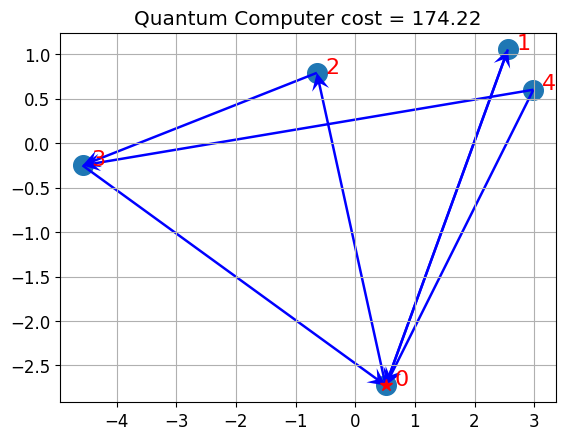

[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]


In [44]:
# Put the solution in a way that is compatible with the classical variables
x_qc = np.zeros(n**2)
kk = 0
for ii in range(n**2):
    if ii // n != ii % n:
        x_qc[ii] = most_likely_bitstring[kk]
        kk += 1

qc_cost = vrp3.objective.evaluate([int(b) for b in most_likely_bitstring[:num_variables]])
visualize_solution(xc, yc, x_qc, qc_cost, n, K, "Quantum Computer") 
print(most_likely_bitstring)

## Plot the top 10 most sampled solutions

[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1]


/tmp/ipykernel_724884/3202210723.py:3: DeprecationWarning: Insufficient bit width provided. This behavior will raise an error in the future.
  result = np.binary_repr(integer, width=num_bits)


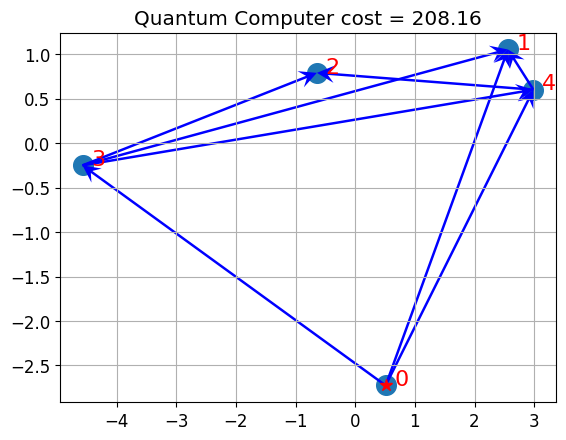

[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1]


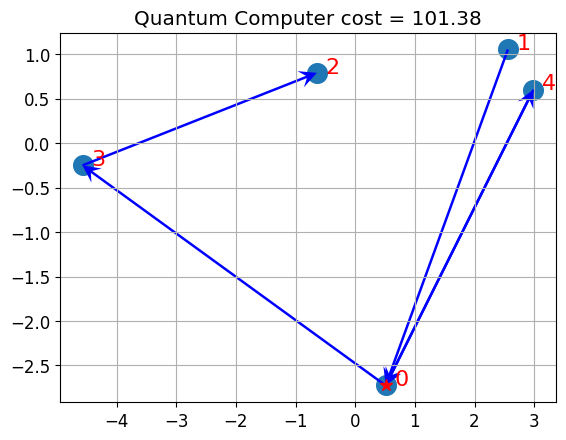

[1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]


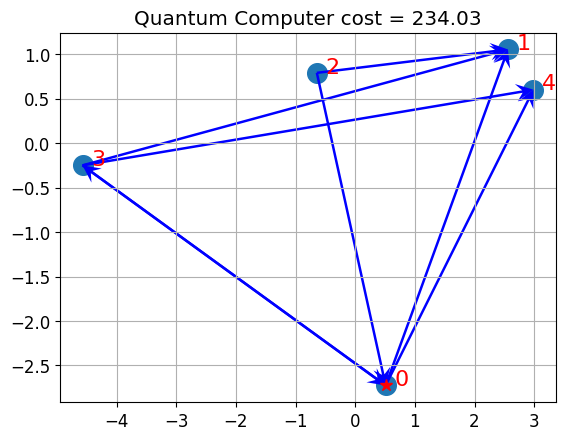

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1]


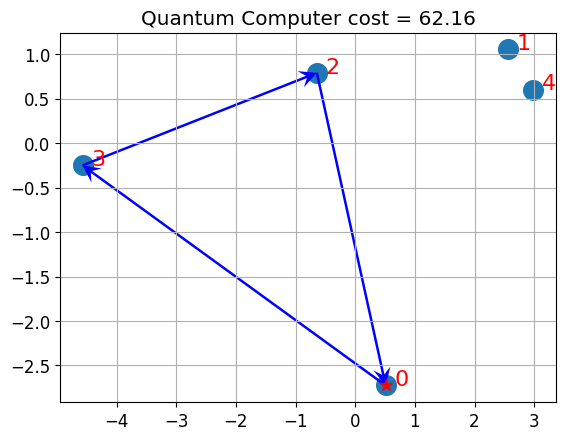

[0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1]


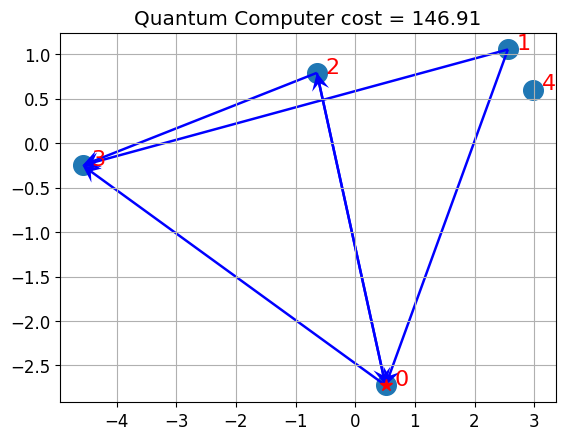

[0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1]


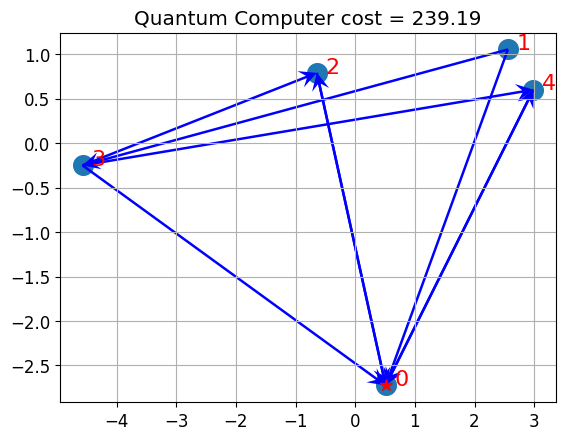

[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1]


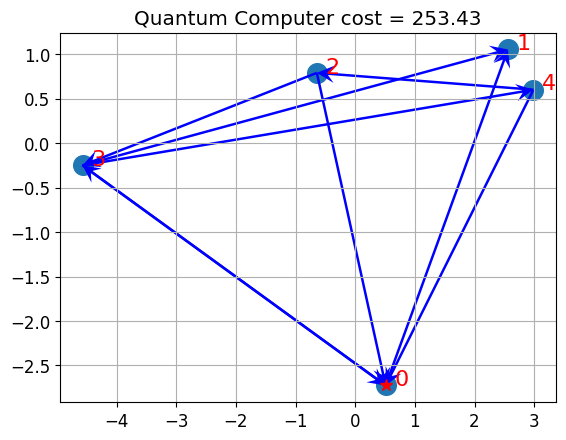

[1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1]


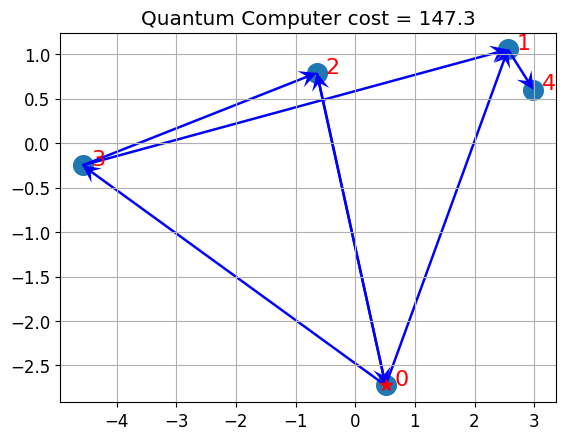

[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1]


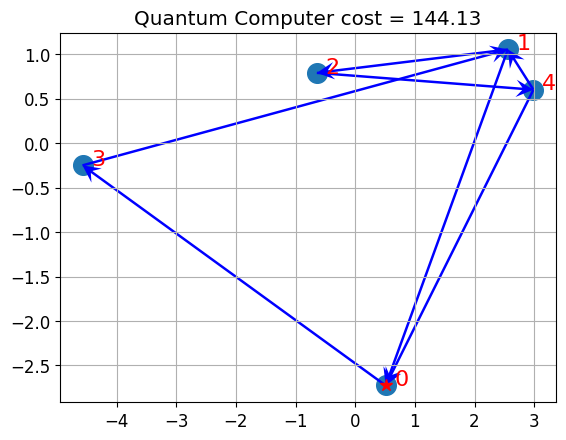

[0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]


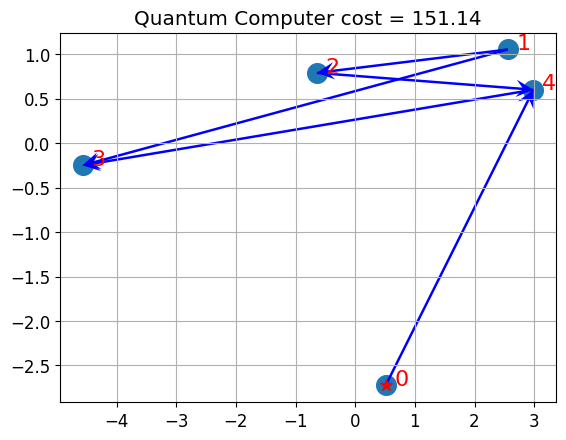

In [45]:
top_indices = np.argsort(np.abs(values))[-10:]
top_keys = [keys[t] for t in top_indices ] 

for k in top_keys:
    m = to_bitstring(k, num_variables)
    m.reverse()
    print(m)
    x_qc = np.zeros(n**2)
    kk = 0
    for ii in range(n**2):
        if ii // n != ii % n:
            x_qc[ii] = m[kk]
            kk += 1

    # qc_cost = calculate_cost(m, simplified_linear, Q)
    qc_cost = vrp3.objective.evaluate([int(b) for b in m[:num_variables]])
    visualize_solution(xc, yc, x_qc, qc_cost, n, K, "Quantum Computer") 

In [46]:
# params_array = np.array(params_list)

# # Extract each parameter series
# iterations = np.arange(len(params_list))
# gamma_0 = params_array[:, 0]
# beta_0 = params_array[:, 1]
# gamma_1 = params_array[:, 2]
# beta_1 = params_array[:, 3]
# gamma_2 = params_array[:, 4]
# beta_2 = params_array[:, 5]
# gamma_3 = params_array[:, 6]
# beta_3 = params_array[:, 7]

# # Plot all parameters
# plt.figure(figsize=(9, 7))
# plt.plot(iterations, gamma_0, marker='o', linestyle='-', label=r'$\gamma_0$')
# plt.plot(iterations, beta_0, marker='s', linestyle='-', label=r'$\beta_0$')
# plt.plot(iterations, gamma_1, marker='^', linestyle='-', label=r'$\gamma_1$')
# plt.plot(iterations, beta_1, marker='d', linestyle='-', label=r'$\beta_1$')
# plt.plot(iterations, gamma_2, marker='^', linestyle='-', label=r'$\gamma_2$')
# plt.plot(iterations, beta_2, marker='d', linestyle='-', label=r'$\beta_2$')
# plt.plot(iterations, gamma_3, marker='^', linestyle='-', label=r'$\gamma_3$')
# plt.plot(iterations, beta_3, marker='d', linestyle='-', label=r'$\beta_3$')

# # Labels and legend
# plt.xlabel("Iteration")
# plt.ylabel("Parameter Value")
# plt.title("QAOA Parameter Evolution")
# plt.legend()
# plt.grid(True)

# # Show the plot
# plt.show()

In [47]:
# Feasible vitstrings in the top M samples
M = 100
sorted_items = sorted(normalized_bits.items(), key=lambda x: x[1], reverse=True)
top_M = sorted_items[:M]

bitstrings = [bs for bs, f in top_M]
freqs = [f for bs, f in top_M]

feasible_flags = []
feasible_freqs = []

for bs, f in top_M:
    # convert string to binary array (last 12 bits, reversed)
    x = np.array([int(b) for b in bs[-num_variables:][::-1]])
    feasible = vrp3.is_feasible(x)
    feasible_flags.append(feasible)
    if feasible:
        feasible_freqs.append(f)

# Count feasible bitstrings
feasible_count = sum(feasible_flags)
fraction_feasible = feasible_count / M

# Weighted fraction by frequencies
total_freq = sum(freqs)
feasible_freq_sum = sum(feasible_freqs)
fraction_feasible_weighted = feasible_freq_sum / total_freq

print(f"Feasible (count): {feasible_count}/{M}")
print(f"Fraction feasible (count): {fraction_feasible:.2%}")
print(f"Fraction feasible (weighted by frequency): {fraction_feasible_weighted:.2%}")

Feasible (count): 1/100
Fraction feasible (count): 1.00%
Fraction feasible (weighted by frequency): 0.96%


In [48]:
# Feasible bitstrings in all samples
feasible_flags = []
feasible_freqs = []
idx = 0
for bs, f in sorted_items:
    # convert string to binary array (last 12 bits, reversed)
    x = np.array([int(b) for b in bs[-num_variables:][::-1]])
    feasible = vrp3.is_feasible(x)
    feasible_flags.append(feasible)
    if feasible:
        feasible_freqs.append(f)
        m = [int(b) for b in bs[-num_variables:][::-1]]
        print(vrp3.objective.evaluate([int(b) for b in m[:num_variables]]), idx)
    idx += 1
        

# Count feasible bitstrings
feasible_count = sum(feasible_flags)
fraction_feasible = feasible_count / idx

# Weighted fraction by frequencies
total_freq = sum(freqs)
feasible_freq_sum = sum(feasible_freqs)
fraction_feasible_weighted = feasible_freq_sum / total_freq

print(f"Feasible (count): {feasible_count}/{idx}")
print(f"Fraction feasible (count): {fraction_feasible:.2%}")
print(f"Fraction feasible (weighted by frequency): {fraction_feasible_weighted:.2%}")

98.26867087231528 38
142.95308402581293 4604
173.51630901901 7787
Feasible (count): 3/9996
Fraction feasible (count): 0.03%
Fraction feasible (weighted by frequency): 2.88%


## Classical solution

In [49]:
sol = mdl.solve(log_output=True)

for var in mdl.iter_variables():
    print(var.name, var.solution_value)

Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
Reduced MIP has 21 rows, 20 columns, and 88 nonzeros.
Reduced MIP has 20 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Found incumbent of value 98.268671 after 0.00 sec. (0.12 ticks)
Probing time = 0.00 sec. (0.02 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 21 rows, 20 columns, and 88 nonzeros.
Reduced MIP has 20 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.06 ticks)
Probing time = 0.00 sec. (0.02 ticks)
Clique table members: 14.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 32 threads.
Root relaxation solution time = 0.00 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap



Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.00 ticks)
Parallel b&c, 32 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.00 ticks)


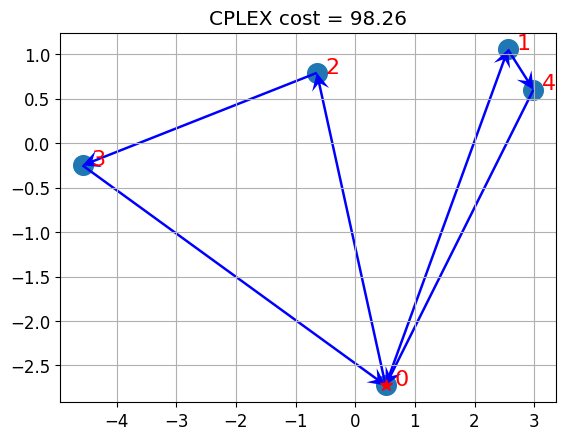

In [50]:
def docplex_to_flat_x(mdl, n, var_prefix="x_"):
    """Extracts x_ij variables from a solved DOcplex model into a flat n*n array."""
    x_flat = np.zeros(n*n, dtype=float)
    for var in mdl.iter_variables():
        name = var.name  # e.g., "x_3_7"
        if not name.startswith(var_prefix):
            continue
        _, si, sj = name.split("_")
        i, j = int(si), int(sj)
        x_flat[i*n + j] = 1.0 if var.solution_value > 0.5 else 0.0
    return x_flat

# After solving:
sol = mdl.solve(log_output=True)
assert sol is not None, "No solution found."

x_cls = docplex_to_flat_x(mdl, n)
cls_cost = sol.objective_value

visualize_solution(xc, yc, x_cls, cls_cost, n, K, "CPLEX")